# Cleaning Modes With Rational Filters

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy

## Data

Download data

In [26]:
home_dir = "./MDC_waveforms/"

In [27]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [28]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

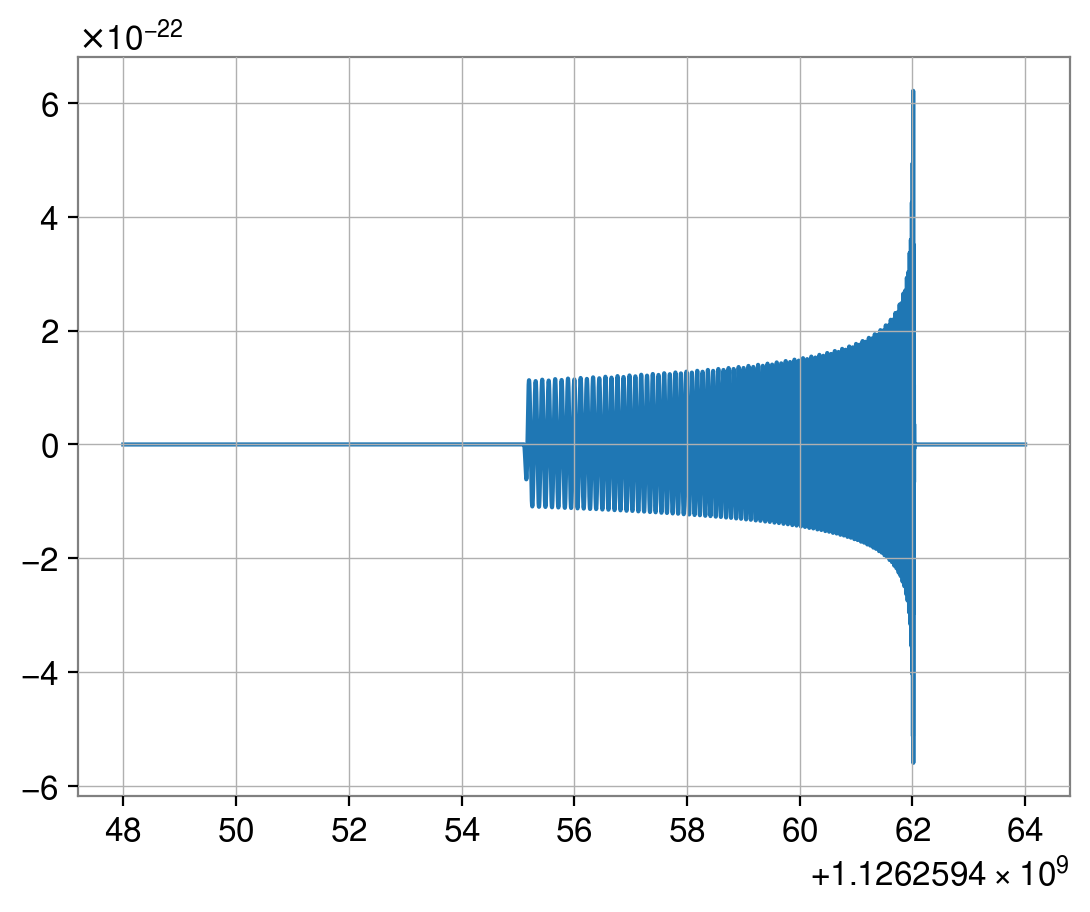

In [73]:
pl.plot(H_data)
# pl.plot(L_data)

In [74]:
H_waveform = qnm_filter.Data(H_data.value, index = H_data.times.value)
L_waveform = qnm_filter.Data(L_data.value, index = L_data.times.value)

In [193]:
peak_time = H_data.times.value[np.argmax(H_waveform)]
SSB_peak_time = peak_time - 0.014685396838313368

In [194]:
# np.savez("Systematics_MDC_Realisation0_H.npz", index = H_waveform.index, values = H_waveform.values)
# np.savez("Systematics_MDC_Realisation0_L.npz", index = L_waveform.index, values = L_waveform.values)

## Filter

In [451]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+9e-3, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [452]:
fit.original_data['H1'] = H_waveform

In [453]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

In [454]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 1e-23**2
fit.acfs['H1'] = qnm_filter.Data(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()

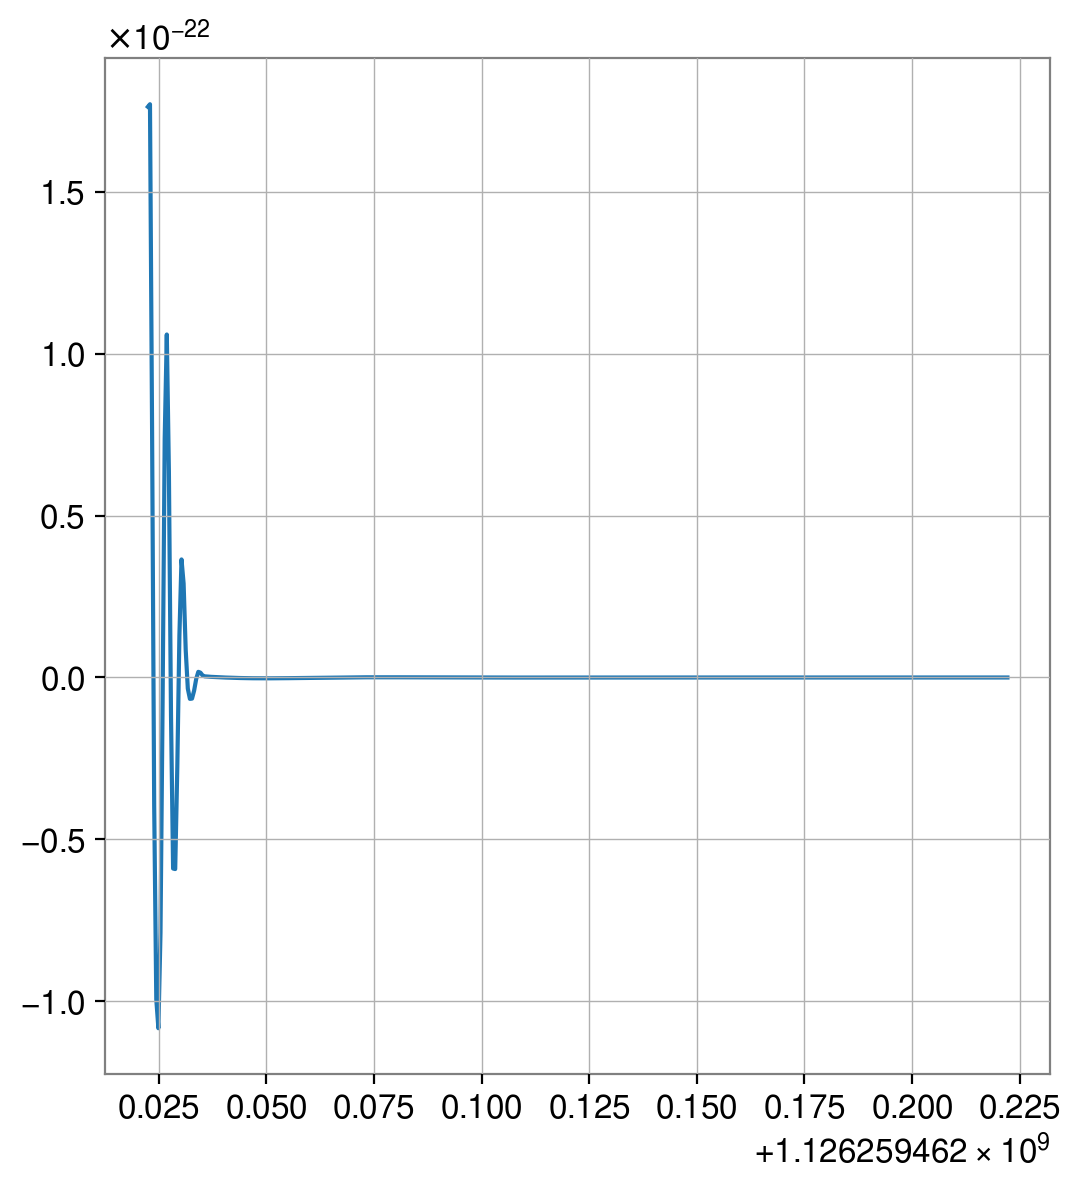

In [455]:
fit.first_index()
pl.plot(fit.truncate_data(fit.original_data)['H1'])

In [456]:
template = fit.truncate_data(fit.original_data)['H1']

In [457]:
fit.compute_SNR(0, template, 'H1', optimal=True)

35.86807308598992

In [458]:
delta_mass = 1.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [459]:
fit.first_index()
likelihood_data, evidence220 = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, '$\\chi_f$')

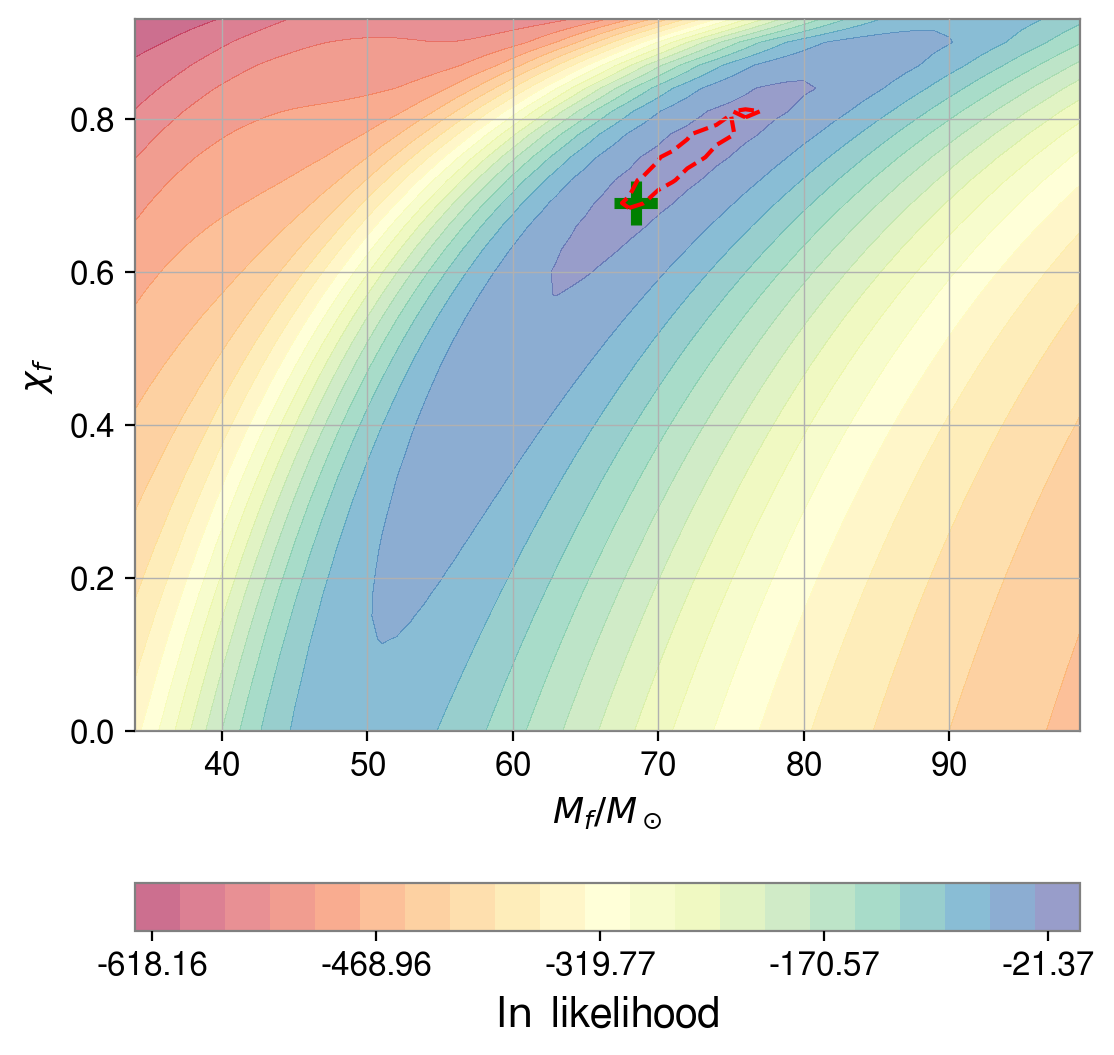

In [460]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [461]:
# Probability = e**likelihood
# Normalise probability 
# Average = probability*mass / chi
# Distance = epsilon definition from paper
# Expand M and chi region - before running on cluster

In [462]:
evidence220

-19.603719101717658

In [436]:
evidence210440

5.728558972970878

In [422]:
evidence210

5.408425299450415

In [410]:
evidence440

3.80308776005406

In [411]:
evidence220

2.996207173352067

In [ ]:
220, 221, 222, 210, 440, 330

In [438]:
import qnm
qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=0.71)[0]

(0.5371215967617101-0.08040291793305679j)

In [439]:
qnm.modes_cache(s=-2, l=2, m=1, n=0)(a=0.71)[0]

(0.4573148056129102-0.08176615773254976j)